# Linear Regression
Regression is an approach to finding function $f(x)$, that models the conditional expectation of $Y$ given X:

$$
f(x) = E[Y|X=x]
$$

In linear regression, we assume that this function is globally linear (see [parent README.md](../README.md) for the meaning of this.).

In regression, minimizing the sum of square residuals by finding the the minimizing set of parameters is called the least squared solution,
and the regression function when viewed in a statistical sense is the solution to least squares.

For linear regression,there is an analytical solution derived from linear algebra:
$$
\hat{\vec{b}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T*\vec{y}
$$

Alternatively, when direct matrix inversion is computationally prohibitive (due to its cubic complexity in the number of features, O(p³)), iterative methods like (mini-)batch gradient descent are preferred (O(np) per iteration). This is where we estimate the gradient using the minibatch.

While the analytical solution, in its purest form, requires a global computation on the entire dataset, making it difficult to directly parallelize in the same way as gradient descent is and the tool ecosystem is very mature for optimizing in this way.

Assume here * refers to matrix multiplication, unless otherwise noted.


$$
Loss = (\vec{y} - \mathbf{X}\vec{b})^T(\vec{y} - \mathbf{X}\vec{b}) \\
\forall (\forall \mathbf{X}_{b} \in \mathbf{X}) \in N_{trainiter} \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M *\nabla_{\hat{\vec{b}}} Loss \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M * 2\mathbf{X}_b^T*(\vec{y} - \mathbf{X}_b \hat{\vec{b}})
$$

## Assumptions:
* Can have additive error, $ y = f(x) + \epsilon $, and uncorrelated with x ( $\epsilon \perp X$) constant variance and usually $\epsilon  \sim N(0,\sigma^2)$. This helps for further statistical analysis.
* Globally linear f(x)

## Example:
Lets generate some data using a linear model with additive error, and use both the gradient based and analytical model to see if we can get the original parameters.


In [1]:
import numpy as np

coefficients = np.array([0.1, 5]).T
bias = np.array([3])

noise = np.random.normal(0, 1, (1000))

input = np.random.uniform(-1.0, 1.0, (1000, 2))

output = noise + input @ coefficients + bias

/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1685306300.py:10: RuntimeWarning: divide by zero encountered in matmul
  output = noise + input @ coefficients + bias
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1685306300.py:10: RuntimeWarning: overflow encountered in matmul
  output = noise + input @ coefficients + bias
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1685306300.py:10: RuntimeWarning: invalid value encountered in matmul
  output = noise + input @ coefficients + bias


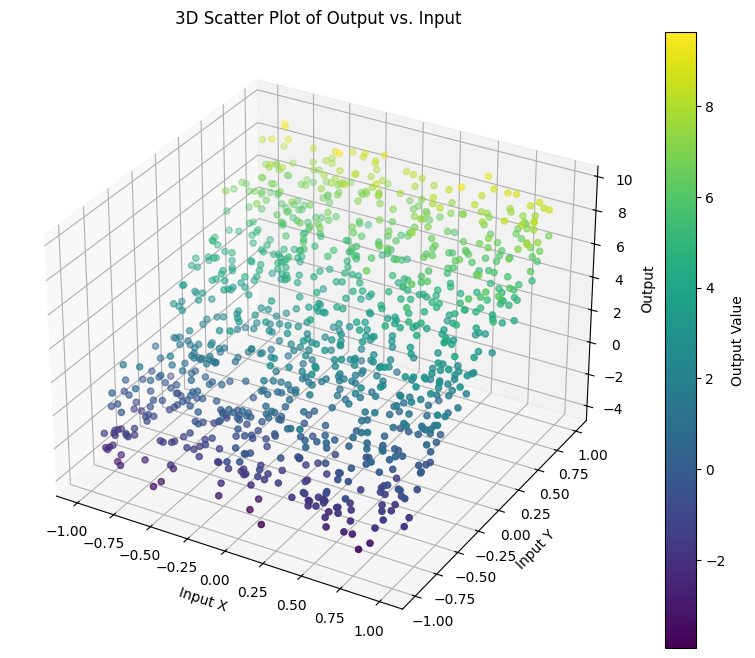

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(input[:, 0], input[:, 1], output, c=output, cmap='viridis', marker='o')
ax.set_xlabel("Input X")
ax.set_ylabel("Input Y")
ax.set_zlabel("Output")
ax.set_title("3D Scatter Plot of Output vs. Input")
fig.colorbar(scatter, label="Output Value")
plt.show()

In [3]:
# analytical approach:
inputWithBias = np.hstack([input, np.ones((input.shape[0], 1))])
def analyticalLinearRegression(inputWithBias, output, debug=True):
    coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
    mse = np.sum((output - inputWithBias @ coefficientsEstimateAnalytical) ** 2) / output.shape[0]
    if debug:
        print(f"mse: {mse}")
    return coefficientsEstimateAnalytical
coefficientsEstimateAnalytical = analyticalLinearRegression(inputWithBias, output)
print(f"Estimated coefficients: {coefficientsEstimateAnalytical[:-1]}, true coefficients: {coefficients}")
print(f"Estimated bias: {coefficientsEstimateAnalytical[-1]}, true bias: {bias}")

mse: 0.970383718956098
Estimated coefficients: [0.09088159 4.99898308], true coefficients: [0.1 5. ]
Estimated bias: 3.015913576833118, true bias: [3]


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/4189900540.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/4189900540.py:4: RuntimeWarning: overflow encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/4189900540.py:4: RuntimeWarning: invalid value encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/4189900540.py:5: RuntimeWarning: divide by zero encountered in matmul
  mse = np.sum((output - inputWithBias @ coefficientsEstimateAnalytical) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv44000

In [4]:
# gradient based approach:
def gradientBasedLinearRegression(inputWithBias, output, debug=True):
    coefficientsEstimateGradient = np.random.normal(0, 1, (3))
    batchSize = 10
    learningRate = 0.01
    epochs = 10
    for epoch in range(epochs):
        for batch in range(inputWithBias.shape[0] // batchSize):
            batchInput = inputWithBias[batchSize * batch : batchSize * batch + batchSize]
            batchOutput = output[batchSize * batch : batchSize * batch + batchSize]
            coefficientsEstimateGradient += learningRate * 1 / batchInput.shape[0] * 2 * batchInput.T @ (batchOutput - batchInput @ coefficientsEstimateGradient)
        epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
        if debug==True:
            print(f"end epoch {epoch + 1}, mse: {epochalMSE}")
    return coefficientsEstimateGradient
coefficientsEstimateGradient = gradientBasedLinearRegression(inputWithBias, output)

end epoch 1, mse: 3.8225705076730265
end epoch 2, mse: 1.6763102907795147
end epoch 3, mse: 1.156227032753828
end epoch 4, mse: 1.0195761995157828
end epoch 5, mse: 0.9834776878510751
end epoch 6, mse: 0.9739477562656772
end epoch 7, mse: 0.9714367201902551
end epoch 8, mse: 0.970777543568915
end epoch 9, mse: 0.9706057551286059
end epoch 10, mse: 0.9705616322355255


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2827835301.py:12: RuntimeWarning: divide by zero encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2827835301.py:12: RuntimeWarning: overflow encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2827835301.py:12: RuntimeWarning: invalid value encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]


In [5]:
print(f"gradient coefficients + intercept: {coefficientsEstimateGradient}, and analytical{ coefficientsEstimateAnalytical}")

import statsmodels.formula.api as smf
import pandas as pd
df = pd.DataFrame(input, columns=['feature_1', 'feature_2'])
df['target_output'] = output
formula = 'target_output ~ feature_1 + feature_2'
model_formula = smf.ols(formula=formula, data=df)
results_formula = model_formula.fit()
print("\n--- Statsmodels OLS Results---")
print(results_formula.params)

gradient coefficients + intercept: [0.08966786 4.992224   3.02871935], and analytical[0.09088159 4.99898308 3.01591358]

--- Statsmodels OLS Results---
Intercept    3.015914
feature_1    0.090882
feature_2    4.998983
dtype: float64


This shows they get to the same place.

## Goodness of fit
The goal of goodness-of-fit tests in linear regression is to assess how well the model's assumptions hold and whether the model adequately captures the relationship between the predictors and the response. This goes beyond just minimizing the loss function; it's about ensuring the validity of the model and its interpretations.

The fundamental approach is to use a model output ($\hat{\vec{y}}$) vs residual ($\hat{\vec{y}} - \vec{y}$) plot, this is expected to be a random scatter centered around 0.

If it's not (e.g., a curved pattern or a non-constant variance (not Homoscedasticity)) one can dig further to see which features are non linear by considering feature vs residual plot. 

One could then try to transform the feature/output to have a more linear relationship, or consider another model.


### For interpretability
It's important for interpretability and to make inferences about coefficients to look at and check for multi-colinearity and to look at and check for normality of errors.

#### Multi - collinearity
This violates one of the assumptions that each feature is independent from another $P(X_i | X_j) = P(X_i), \forall i, j$ where $i \neq j$.

Two approaches:

##### VIF
VIF is the Variance Inflation Factor (VIF). It is performing linear regression treating the feature for which you are finding the VIF for as dependent varaible to be predicted by all the other features, then computing $ 1 / (1 - R^2)$ for this model. $R^2$ is 1 - sum of square residuals / total sum of squares, it compares how off we are from predicting the feature over a baseline of just using the average, where 1 means the model is 0 error, than just predicting and 0 means the model explains none of the variance in the VIF feature; it's no better than simply predicting the mean, then The VIF is the reciprocal of (1 - R²), which quantifies how well the model could get on without the feature (since it could be linearly constructed from the others). R² larger is smallest error, so then 1 - R² flips this and reciprical flips it again and R² then larger is smaller error, which would mean that the feature is redundant.

We compute VIFs for each feature and A VIF > 5 (or 10, depending on the context) suggests problematic multicollinearity.

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

After you find features with VIFs, you can look at correlation matrix to find the variables that you can consider dropping then recheck for VIF values. You don't necessarily have to do this for just prediction usage but for interpretability of the coefficients. You could also combine them (average or otherwise), or even use regularization though the simple interpretability that came from the assumptions of independent factors is not valid anymore.

##### Correlation matrix
One could also directly examine the correlation matrix of the predictors. The correlation matrix is derived from covariance matrix, its the covariance matrix divided by the product of the standard deviations of the two variables in each pair- it normalizes the covariance so its always between -1 and 1, removing the scaling differences that would otherwise make covariance a good option to compare how features "move together" which is the condition of multi collinearity that we seek.

Pairwise correlation:
$\rho_{jk} = \frac{\sum_{i=1}^{n} (x_{ij} - \bar{x}_j)(x_{ik} - \bar{x}_k)}{\sigma_i * \sigma_j}$


Efficient Linear Algebra for correlation matrix:


$$
\vec{\bar{x}} = average(\mathbf{X}, dim=0).reshape(1, \mathbf{X}.shape[1]) \\
\mathbf{X_{demenaed}} = \mathbf{X} -\vec{\bar{x}} \\ 
Cov = (\mathbf{X_{demeaned}}^T*\mathbf{X_{demeaned}}) / (\mathbf{X}.shape[0] - 1) \\
StdDevInv = 1 / sqrt(diagnol(Cov)) \\
Correlation = Cov *_{element} StdDevInv.reshape(1,\mathbf{X}.shape[1]) *_{element} StdDevInv.reshape(\mathbf{X}.shape[1], 1)
$$

Here we make use of broadcasting, as Numpy implements it.

Look for high pairwise correlations (e.g., |r| > 0.8 or 0.9), remove those with very high.

#### Normality of errors
To see whether errors are normal, one could plot them with a histogram and see if it's the traditional bell shaped curve, centered around 0 or use normal Q-Q (Quantile - Quantile) plot, where you plot values in Y axis and the standard normal z score for the porportion of sample values below that (altered a bit to avoid infinity z scores) (inverse CDF of standard normal). A 45-degree reference line from 0 is often added and how well the plotted points lines up and where indicate how standard normal the residuals actually are, a straight line indicates a linear relationship though the standard deviation and mean are the slope and offset respectively.

Tests like the Shapiro-Wilk test or Anderson-Darling test provide a p-value to formally test the null hypothesis that the residuals are normally distributed. However, visual inspection with histograms and especially Q-Q plots is often preferred, particularly for understanding *how* the distribution deviates from normality if it does.

If they're not, may want to transform the response variable, for example taking a $log(Y)$ is most common or square root (particulary if its right skew which means mean is greater than median), if it's left skew you can do $1 - log(y)$.

Or consider generalized linear models (GLMs) which do not assume normal 0 centered noise.

/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2842622616.py:2: RuntimeWarning: divide by zero encountered in matmul
  residuals = output - (inputWithBias @ coefficientsEstimateGradient)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2842622616.py:2: RuntimeWarning: overflow encountered in matmul
  residuals = output - (inputWithBias @ coefficientsEstimateGradient)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2842622616.py:2: RuntimeWarning: invalid value encountered in matmul
  residuals = output - (inputWithBias @ coefficientsEstimateGradient)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2842622616.py:3: RuntimeWarning: divide by zero encountered in matmul
  plt.scatter((inputWithBias @ coefficientsEstimateGradient), residuals)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2842622616.py:3: RuntimeWarning: overflow encountered in matmul
  plt.scatter((inputWithBias @ coefficientsEstimateGrad

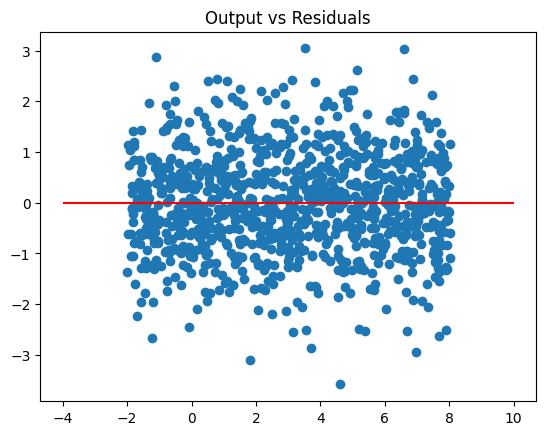

In [6]:
## goodness of fit
residuals = output - (inputWithBias @ coefficientsEstimateGradient)
plt.scatter((inputWithBias @ coefficientsEstimateGradient), residuals)
plt.hlines(0, -4, 10, colors="red")
plt.title("Output vs Residuals");

In [7]:
# looks pretty good, which it should, constant variance 0 noise was used to generate it
# for interpretability, lets do VIF
# VIF = 1 / (1 - R^2) for R^2 value of using other features used regress to feature we are getting VIF from
# R^2 = 1 - SSR / SST where SSR is sum(residuals^2) and SST is sum((y - mean(y))^2)
def VIF(featureIndex, modelInput):
    x = np.hstack([modelInput[:, :featureIndex], modelInput[:, featureIndex + 1:]])
    y = modelInput[:, featureIndex]
    xWithBias = np.hstack([x, np.ones((x.shape[0], 1))])
    coefficients = np.linalg.inv(xWithBias.T @ xWithBias) @ xWithBias.T @ y
    modelOutput = xWithBias @ coefficients
    ssr = np.sum((y - modelOutput)**2)
    residuals = y - modelOutput
    sst = np.sum((y - np.mean(y))**2)
    rSquared = 1 - ssr / sst
    return 1 / (1 - rSquared)

for i in range(input.shape[1]):
    print(f"VIF of index {i}: {VIF(i, input)}")

def correlationMatrix(modelInput):
    means = np.mean(modelInput, axis=0).reshape(1, modelInput.shape[1])
    demeanedX = modelInput - means
    covariance = (demeanedX.T @ demeanedX) / (modelInput.shape[0] - 1)
    standardDeviationInv = 1/ np.sqrt(np.diag(covariance))
    return covariance * standardDeviationInv.reshape(1, modelInput.shape[1]) * standardDeviationInv.reshape(1, modelInput.shape[1]) 

print("Correlation matrix:\n", correlationMatrix(input))

VIF of index 0: 1.0000022417196495
VIF of index 1: 1.0000022417196497
Correlation matrix:
 [[1.         0.00151465]
 [0.00148002 1.        ]]


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1324913310.py:10: RuntimeWarning: divide by zero encountered in matmul
  modelOutput = xWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1324913310.py:10: RuntimeWarning: overflow encountered in matmul
  modelOutput = xWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1324913310.py:10: RuntimeWarning: invalid value encountered in matmul
  modelOutput = xWithBias @ coefficients


In [8]:
# looks like the VIFs indicate a low multi collinearity
# also correlation matrix is pretty much identity
# which is expected
# Using numpy's built-in function
corr_matrix_np = np.corrcoef(input, rowvar=False)
# 'rowvar=False' means columns are variables, rows are observations
print("Correlation matrix (using np.corrcoef):\n", corr_matrix_np)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant # To add the intercept term

X_with_const = add_constant(input)
print("VIFs from statsmodels:\n", [variance_inflation_factor(X_with_const, i + 1) for i in range(input.shape[1])])

## so we are on track, though the correlation coefficient was off, its in the 4th decimal place in a value that ranges from -1 to 1
# so we will chalk it up to rounding errors and exact procedure

Correlation matrix (using np.corrcoef):
 [[1.         0.00149724]
 [0.00149724 1.        ]]
VIFs from statsmodels:
 [np.float64(1.0000022417196495), np.float64(1.0000022417196497)]


## Validation
While goodness-of-fit diagnostics check how well the model fits the data it was trained on and whether assumptions are met, validation focuses on estimating how well the model will perform on new, unseen data. This is crucial for understanding the model's generalization ability and avoiding overfitting, where the model learns noise specific to the training set rather than the underlying relationship.

There are a couple common ways to do this:
1. **Simple test / train split**: One randomly partitions the dataset into a train and test dataset. The train dataset is used to estimate the coefficients of the model and then the test dataset is used to estimate the generalization error (like MSE, or square root of MSE).This is simple but an unlucky split could give you a pessimistic or optimistic estimate of the generalization error.
2. **K-fold cross validation**: One randomly partitions the dataset into K chunks, K - 1 are used to train the model while 1 is used to estimate the generalization error. This is done for each of the K partitions and the estimate of the generalization error is more robust to a random partition's data (since one could look at it's average as a point estimate and it's spread to understand the stability of the generalization error). It does take more to compute. 


In [9]:
# split train and test
splitIndex = int(len(input)*0.8)
trainX = input[:splitIndex]
trainY = output[:splitIndex]

testX = input[splitIndex:]
testY = output[splitIndex:]

# train on train
trainWithBias = np.hstack([trainX, np.ones((len(trainX), 1))])
print("training gradient:")
estimatedCoefficientsGradient = gradientBasedLinearRegression(trainWithBias, trainY)
print()
print("training analytical:")
estimatedCoefficientsAnalytical = analyticalLinearRegression(trainWithBias, trainY)
print()
# validate on test:
print("validating on test:")
testWithBias = np.hstack([testX, np.ones((len(testX), 1))])
print()
print("analytical mse:")
print(((testWithBias @ estimatedCoefficientsAnalytical - testY)**2).sum() / len(testX))
print()
print("gradient mse:")
print(((testWithBias @ estimatedCoefficientsGradient - testY)**2).sum() / len(testX))

training gradient:
end epoch 1, mse: 5.076225978539882
end epoch 2, mse: 2.2703424547557987
end epoch 3, mse: 1.3927591365716205
end epoch 4, mse: 1.0944324676392196
end epoch 5, mse: 0.9923070372984136
end epoch 6, mse: 0.957441734759877
end epoch 7, mse: 0.9456089853994603
end epoch 8, mse: 0.9416347069770638
end epoch 9, mse: 0.9403245768447139
end epoch 10, mse: 0.9399075249206236

training analytical:
mse: 0.939731925528635

validating on test:

analytical mse:
1.0934585387410993

gradient mse:
1.0931269733934657


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2827835301.py:12: RuntimeWarning: divide by zero encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2827835301.py:12: RuntimeWarning: overflow encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2827835301.py:12: RuntimeWarning: invalid value encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/4189900540.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/

/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2827835301.py:12: RuntimeWarning: divide by zero encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2827835301.py:12: RuntimeWarning: overflow encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/2827835301.py:12: RuntimeWarning: invalid value encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/4189900540.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/

analytical:
0.9772034033559379
0.22656641360896979
gradient:
0.97722389956581
0.2274586862756784


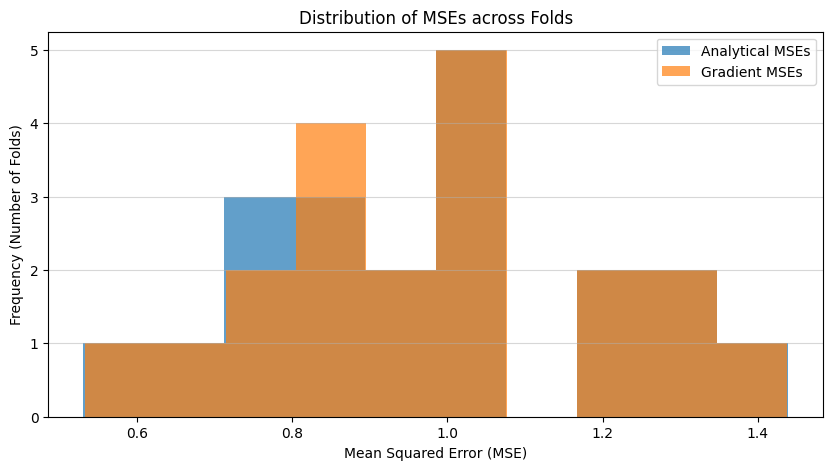

In [10]:
# k fold cross validation
# split everything
numFolds = 20
itemsPerFold =inputWithBias.shape[0] // numFolds
folds = []
targets = []
numIndices = inputWithBias.shape[0]

indices = np.random.permutation(numIndices)
outputMixed = output[indices]
inputWithBiasMixed = inputWithBias[indices]


folds = np.array_split(inputWithBiasMixed, numFolds)
targets = np.array_split(outputMixed, numFolds)
# for each do the process infer on the iterated fold
mses = []
for foldIndex, fold in enumerate(folds):
    trainX = np.vstack([folds[x] for x in range(len(folds)) if x != foldIndex])
    trainY = np.hstack([targets[x] for x in range(len(targets)) if x != foldIndex])

    testX = fold
    testY = targets[foldIndex]
    estimatedCoefficientsGradient = gradientBasedLinearRegression(trainX, trainY, debug=False)
    estimatedCoefficientsAnalytical = analyticalLinearRegression(trainX, trainY, debug=False)
    mse = (((testX @ estimatedCoefficientsAnalytical - testY)**2).sum() / len(testX), ((testX @ estimatedCoefficientsGradient - testY)**2).sum() / len(testX))
    mses.append(mse)
# average, capture spread, maybe distribution
plt.figure(figsize=(10, 5))
print("analytical:")
print(np.array([m[0] for m in mses]).mean())
print(np.array([m[0] for m in mses]).std())
plt.hist([m[0] for m in mses],  alpha=0.7, label='Analytical MSEs')

print("gradient:")
print(np.array([m[1] for m in mses]).mean())
print(np.array([m[1] for m in mses]).std())
plt.hist([m[1] for m in mses],  alpha=0.7, label='Gradient MSEs')
plt.title('Distribution of MSEs across Folds')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency (Number of Folds)')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

plt.show()

# Model Complexity
Model complexity for linear regression can be controlled by both regularization and feature selection. Both of these reduce the variance (sensitivty to the training data) and introduce a bias.

## Regularization
Regularization introduces a penalty based on coefficient size. This penalty helps reduce model variance and improve generalization error, especially when dealing with multicollinearity or high-dimensional data. However, it makes direct interpretation of the coefficients harder because it introduces bias, shrinking them towards 0 compared to the OLS estimates.

Since the penalty is applied to the coefficient size, it's crucial to standardize features (e.g., subtract mean, divide by standard deviation) before applying regularization. This ensures features are on a comparable scale and the penalty is applied fairly, rather than being influenced by arbitrary units. Standardization adds a layer to interpretation, as coefficients then relate to changes in standard deviations of the predictors.

Also regularization excludes the intercept (or bias) term since this term isn't a measure of sensitivity to the features as the feature coefficients are, and the bias term itself is origin-dependent (really the baseline, if all coefficients are zero), and penalizing it would undesirably tie the regularization outcome to the choice of origin (or data centering), which is generally not the goal. The goal is to penalize feature sensitivity (slopes), not the overall offset (intercept).

There are two types of regularization adding either or both to $ sum((Y - \mathbf{X}\Beta)^2)$:
1. Lasso regularization or adding a $\lambda * \sum_i|\beta_i|$. Lasso stands for least absolute shrinkage and selection operator. If you look at the slope for absolute value compared to L2 (quadratic) the slope is stronger as you get closer to 0, therefore it tends to shrink coefficients and produce sparse models. Cannot be solved in analytical closed form, use proximal gradient descent (split the coefficient update into two):
    1. The gradient descent normal update (as described above in this notebook). Let's say this gives you $\vec{z}$.
    2. Proximal update, which is $\beta_j = sign(z_j)*max(|z_j| - \eta, 0)$, this essentially drives the ceofficient closer to 0 if it's not already in some threshold within 0. $η=α*\lambda$. Proximal gradient descent has been shown to be convex.


2. Ridge regularizaton or adding a $\lambda * \sum_i\beta_i^2$. Ridge is named that because its equivalent to adding a $\lambda*\mathbf{I}$ to the matrix before inverting, which looks like a series of peaks. It forces correlated predictors to "share" the credit because fo the quadratic nature. Instead of one coefficient becoming huge positive and a correlated one huge negative, Ridge tends to shrink both of their coefficients towards each other and towards zero. Can be solved analytical closed form as well: $\hat{\mathbf{b}}_{\text{Ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$, as well as gradient descent (gradient is only different $\nabla_{\beta} L_{\text{Ridge}}(\beta) = -2\mathbf{X}^T(Y - \mathbf{X}\beta) + 2\lambda\beta$).


3. Mix Lasso and ridge for elastic net regression, using a single $\alpha$ for both and ratio ($\rho$) of L1 and L2. so it would be $\alpha*(\rho*\sum_i|\beta_i| + (1-\rho)*1/2*\sum_i\beta_i^2)$. This would similarily be optimized using proximal gradient descent:
    1. The gradient descent normal update (as described above in this notebook) with the L2 regularization parameter ($(1-\rho)*1/2$). Let's say this gives you $\vec{z}$.
    2. Proximal update, which is $\beta_j = sign(z_j)*max(|z_j| - \eta, 0)$, this essentially drives the ceofficient closer to 0 if it's not already in some threshold within 0. $η=α*\lambda$

Generally the weights add a retriction on the coefficient space that's being searched, in the bias variance decomposition $E[(y - \mathbf{x}.T\beta)^2] = bias^2 + Variance + \sigma^2$, bias is increased, but variance is reduced as well, so you can end up with a more stable estimate, thats not so dependent on the training data (less sensitive).

When searching for hyperparameters one could take the training set and further split it into a validation and training set, where the training set is used to train the parameters, and the validation set is used to find the best hyper parameters. or partition the dataset into a train (80-90%) and test, then on the train perform k-fold validation to find best hyper parameters, retrain on entire training set and report the test set performance of thsi model as the generalization error.


In [11]:
# lets standardize
inputStd = (input - input.mean(0)) / input.std(0)

# need to transform the y too to remove bias
outputDemeaned = output - output.mean()

In [12]:
n = 57
np.eye(n) @ inputStd[57 - n:57].astype(np.float64)
print("Runtime error")
# numpy bug: RuntimeWarning: invalid value encountered in matmul
# https://github.com/numpy/numpy/issues/28687 

Runtime error


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/246870512.py:2: RuntimeWarning: divide by zero encountered in matmul
  np.eye(n) @ inputStd[57 - n:57].astype(np.float64)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/246870512.py:2: RuntimeWarning: overflow encountered in matmul
  np.eye(n) @ inputStd[57 - n:57].astype(np.float64)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/246870512.py:2: RuntimeWarning: invalid value encountered in matmul
  np.eye(n) @ inputStd[57 - n:57].astype(np.float64)


In [13]:
# ridge regression (L2):
def ridgeRegressionAnalytical(inputStd, y, strength = 1):
    return np.linalg.inv(inputStd.T @ inputStd + strength*np.identity(inputStd.shape[1])) @ inputStd.T @ y

print(f"Ridge regression analytical solution:{ridgeRegressionAnalytical(inputStd, outputDemeaned)}")
print(f"train mse: {((inputStd @ ridgeRegressionAnalytical(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

def ridgeRegressionGradient(x, y, strength = 1, learningRate=.001, epochs=1000, batchSize = 10, debug=True ):
    coefficientsEstimate = np.random.standard_normal(((2)))
    splitX = np.array_split(x, x.shape[0] // batchSize)
    splitY = np.array_split(y, x.shape[0] // batchSize)
    for e in range(epochs):
        for batchIndex in range(len(splitX)):
            batchInput = splitX[batchIndex]
            batchOutput = splitY[batchIndex]
            coefficientsEstimate += learningRate*2/ batchInput.shape[0] * batchInput.T@(batchOutput - batchInput @ coefficientsEstimate) - learningRate * 2 * strength * coefficientsEstimate / (x.shape[0] / batchInput.shape[0])
    return coefficientsEstimate

print(f"Ridge regression gradient solution: {ridgeRegressionGradient(x=inputStd, y=outputDemeaned)}")
print(f"train mse: {((inputStd @ ridgeRegressionGradient(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

Ridge regression analytical solution:[0.05283909 2.87278742]
train mse: 0.9703919742196022 
Ridge regression gradient solution: [0.05197588 2.84731887]


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1170723015.py:6: RuntimeWarning: divide by zero encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionAnalytical(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1170723015.py:6: RuntimeWarning: overflow encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionAnalytical(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1170723015.py:6: RuntimeWarning: invalid value encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionAnalytical(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")


train mse: 0.9711878551335553 


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1170723015.py:20: RuntimeWarning: divide by zero encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionGradient(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1170723015.py:20: RuntimeWarning: overflow encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionGradient(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/1170723015.py:20: RuntimeWarning: invalid value encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionGradient(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")


In [14]:
print(f"Ridge regression gradient solution: {ridgeRegressionGradient(x=inputStd, y=outputDemeaned, strength=1)}")
print(f"Ridge regression analytical solution:{ridgeRegressionAnalytical(inputStd, outputDemeaned, strength=1)}")

Ridge regression gradient solution: [0.05197588 2.84731887]
Ridge regression analytical solution:[0.05283909 2.87278742]


In [15]:
print(f"Ridge regression gradient solution: {ridgeRegressionGradient(x=inputStd, y=outputDemeaned, strength=100)}")
print(f"Ridge regression analytical solution:{ridgeRegressionAnalytical(inputStd, outputDemeaned, strength=100)}")
# looks like the difference is even more pronounced as strenght goes up.
# I guess the reason is because additional hyper parameters for learning rate and epochs, though not entirely a satisfying outcome.

Ridge regression gradient solution: [0.02734794 1.43741187]
Ridge regression analytical solution:[0.04843548 2.61424255]


In [16]:
def lassoRegression(x, y, strength = 1, learningRate=.001, epochs=1000, batchSize = 10, debug=True ):
    coefficientsEstimate = np.random.standard_normal(((2)))
    splitX = np.array_split(x, x.shape[0] // batchSize)
    splitY = np.array_split(y, x.shape[0] // batchSize)
    for e in range(epochs):
        for batchIndex in range(len(splitX)):
            batchInput = splitX[batchIndex]
            batchOutput = splitY[batchIndex]
            coefficientsEstimate += learningRate*2/ batchInput.shape[0] * batchInput.T@(batchOutput - batchInput @ coefficientsEstimate)
            # lasso update
            threshold = learningRate*strength
            coefficientsEstimate = np.sign(coefficientsEstimate)*np.maximum(np.abs(coefficientsEstimate) - threshold, 0)
    return coefficientsEstimate

print(f"Lasso regression solution: {lassoRegression(x=inputStd, y=outputDemeaned)}")
print(f"train mse: {((inputStd @ lassoRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

def elasticNetRegression(x, y, strength = 1, l1Ratio = 0.5, learningRate=.001, epochs=1000, batchSize = 10, debug=True ):
    coefficientsEstimate = np.random.standard_normal(((2)))
    splitX = np.array_split(x, x.shape[0] // batchSize)
    splitY = np.array_split(y, x.shape[0] // batchSize)
    for e in range(epochs):
        for batchIndex in range(len(splitX)):
            batchInput = splitX[batchIndex]
            batchOutput = splitY[batchIndex]
            # ridge update
            coefficientsEstimate += learningRate*2/ batchInput.shape[0] * batchInput.T@(batchOutput - batchInput @ coefficientsEstimate) - 1/2 * (1-l1Ratio) * learningRate * 2 * strength * coefficientsEstimate / (x.shape[0] / batchInput.shape[0])
            # lasso update
            threshold = learningRate*strength*l1Ratio
            coefficientsEstimate = np.sign(coefficientsEstimate)*np.maximum(np.abs(coefficientsEstimate) - threshold, 0)
    return coefficientsEstimate
print(f"Elastic Net regression solution: {elasticNetRegression(x=inputStd, y=outputDemeaned)}")
print(f"train mse: {((inputStd @ elasticNetRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

Lasso regression solution: [0.         2.37563206]


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/3199510095.py:16: RuntimeWarning: divide by zero encountered in matmul
  print(f"train mse: {((inputStd @ lassoRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/3199510095.py:16: RuntimeWarning: overflow encountered in matmul
  print(f"train mse: {((inputStd @ lassoRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/3199510095.py:16: RuntimeWarning: invalid value encountered in matmul
  print(f"train mse: {((inputStd @ lassoRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")


train mse: 1.2232880915875834 
Elastic Net regression solution: [1.16629892e-03 2.61917395e+00]
train mse: 1.0388837031947733 


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/3199510095.py:33: RuntimeWarning: divide by zero encountered in matmul
  print(f"train mse: {((inputStd @ elasticNetRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/3199510095.py:33: RuntimeWarning: overflow encountered in matmul
  print(f"train mse: {((inputStd @ elasticNetRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/3199510095.py:33: RuntimeWarning: invalid value encountered in matmul
  print(f"train mse: {((inputStd @ elasticNetRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")


## Feature Selection
For the sake of generalization (less degrees of freedom for the optimization to use to overfit), and interpretability (removing redundant features), it may be of use to find an ideal minimal subset of features that gets an acceptable performance.
This can also be viewed as a kind of regularization (discussed earlier) though in a discrete way, rather than continously as discussed in previous methods - an entire feature is removed not just coefficient adjusted.

Though for a subset size of n there are $2^n$ combinations of features to try. Which can be come prohibitive quickly. Practically, this is done in a greedy fashion either from the full set down to just an intercept or building up and selecting a feature to add one at a time, which is quadratic $O(p^2)$ in number of fits, which may not find the optimal subset, but has been empirically shown to be close.

To decide the best subset, one can use p-values (though more brittle since assumptions of feature independence are likely violated), or an information criteria like AIC or validation performance.

There are two ways to do this:
1. Forward stepwise - fit an intercept, then add the "best" feature next.
2. Backward stepwise - start will full set of features regression, remove feature that is "worst".

AIC is Akaike Information Criterion. It tries to capture a measure of generalization performance by including goodness of fit and model complexity:

$AIC = 2k - 2log(L)$

Linear model with additive normal 0 centered noise with constant variance:

$log(L) = -n/2log(2pi) - n/2log(\sigma^2) - 1/(2\sigma^2)*\sum_i e_i^2$

This is minimized.

In [17]:
x = np.arange(0,9).reshape(3,3)
x[:, [1,0]]

array([[1, 0],
       [4, 3],
       [7, 6]])

In [18]:
def AICModel(input, output):
    features = set(list(range(1, input.shape[1]))) # features to try (pooled)
    bestFeatures = [0]
    weights = analyticalLinearRegression(input[:, [(0)]], output)
    bestWeights = weights
    estimate = input[:, [(0)]] @ weights
    sse = (estimate - output) @ (estimate - output)
    n = input.shape[0]
    varEstimate = sse / n 
    k = 2
    logLikelihood = -n / 2 * np.log(2*np.pi) - n / 2 * np.log(varEstimate) - 1/2/varEstimate*sse
    AIC = 2*k - 2*logLikelihood
    while features:
        oldAIC = AIC
        bestFeature = -1
        for featureIndex in features:
            weights = analyticalLinearRegression(input[:, bestFeatures + [featureIndex]], output)
            estimate = input[:, bestFeatures + [featureIndex]] @ weights
            sse = (estimate - output) @ (estimate - output)
            n = input.shape[0]
            varEstimate = sse / n 
            kTemp = k + 1
            logLikelihood = -n / 2 * np.log(2*np.pi) - n / 2 * np.log(varEstimate) - 1/2/varEstimate*sse
            AICForThisModel = 2*kTemp - 2*logLikelihood
            if AICForThisModel < AIC:
                AIC = AICForThisModel
                bestFeature =  featureIndex
                bestWeights = weights
        if AIC == oldAIC:
            break
        bestFeatures.append(bestFeature)
        features.remove(bestFeature)
        k += 1
    return AIC, bestWeights, bestFeatures
        

AICModel(inputWithBias, output)

mse: 18.525506549570164
mse: 10.056132874709283
mse: 9.239786407647498
mse: 0.970383718956098


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/4189900540.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/4189900540.py:4: RuntimeWarning: overflow encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/4189900540.py:4: RuntimeWarning: invalid value encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/84022469.py:7: RuntimeWarning: divide by zero encountered in matmul
  sse = (estimate - output) @ (estimate - output)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_54552/84022469.py:7: RuntimeWarni

(np.float64(2815.8133672535837),
 array([0.09088159, 3.01591358, 4.99898308]),
 [0, 2, 1])

## Interpretability
The biggest allure to linear regression is it's interpetability. Holding everything else constant a unit change in some covariate correlates with an increase in the response by the coefficient of that covariate. 

The intercept is the solution if all covariates are zero.

If the input is standardized, then its a change in the standard deviation of the covariate.

However this only holds if the assumptions we've discussed so far are valid:

1. Linearity - the relationship is a linear one between covariate and response - (Check with residual plots).
1. Independent features - the features are independent among themselves, not correlated as that would offend the assumption of holding everything else constant - (Check VIFs).
1. No regularization - regularization adds a bias to make the coefficients smaller (and depending on type can move coefficients differently).

### Statistically
From a statistical point of view, with the following additional assumptions, we can start to make inferential statements (confidence bands) about the true coefficient (s) and about the response.

1. Additive zero meaned gaussian noise with constant variance (Check with residual plots).

#### Coefficient Inferences

To get the standard error (which lets us build confidence intervals), we need variance, which can be shown to be equal to:

$$
Var(\hat{\vec{\beta}} | \mathbf{X}) = \sigma^2 (\mathbf{X}^T\mathbf{X})^{-1}
$$

$$
s^2 = \hat{\sigma}^2 = \frac{RSS}{n - p - 1} = \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{n - p - 1} = \frac{(\vec{y} - \mathbf{X}\hat{\vec{\beta}})^T(\vec{y} - \mathbf{X}\hat{\vec{\beta}})}{n - p - 1}
$$

where `n` is the number of observations and `p` is the number of predictors (excluding the intercept). The term `n - p - 1` represents the degrees of freedom for the error estimate.

The estimated variance-covariance matrix of `β̂` is then:

$$
\hat{Var}(\hat{\vec{\beta}} | \mathbf{X}) = s^2 (\mathbf{X}^T\mathbf{X})^{-1}
$$

The **Standard Error (SE)** for an individual coefficient estimate `β̂ⱼ` is the square root of the j-th diagonal element of this estimated variance-covariance matrix:

$$
SE(\hat{\beta}_j) = \sqrt{s^2 [(\mathbf{X}^T\mathbf{X})^{-1}]_{jj}}
$$


A (1 - α) * 100% confidence interval for `βⱼ` is calculated as:

$$
\hat{\beta}_j \pm t_{\alpha/2, n-p-1} \times SE(\hat{\beta}_j)
$$

Where:
*   `β̂ⱼ` is the point estimate for the coefficient.
*   `SE(β̂ⱼ)` is the standard error of the estimate.
*   `t_(α/2, n-p-1)` is the critical value from the t-distribution with `n-p-1` degrees of freedom that leaves `α/2` probability in the upper tail (e.g., for a 95% CI, α = 0.05, and we look up the t-value for 0.025).

There is also hypothesis testing that can be performed to determine whether a covariate has a statistically significant linear relationship with response, and this can be formed into a hypothesis test:
* Null hypothesis is predictor has no linear relationship ($\beta_j == 0$)
* Alternative hypothesis is that it has a linear relationship ($\beta_j <> 0$)

$$
t = \frac{\hat{\beta}_j - 0}{SE(\hat{\beta}_j)} = \frac{\hat{\beta}_j}{SE(\hat{\beta}_j)}
$$


Under the null hypothesis and the model assumptions, this t-statistic follows a t-distribution with `n - p - 1` degrees of freedom.

**Decision Rule:**
1.  **Using p-value:** Calculate the probability of observing a t-statistic as extreme as, or more extreme than, the one calculated, assuming `H₀` is true. This is the p-value. If the p-value is less than the chosen significance level `α` (e.g., 0.05), we reject `H₀` in favor of `H₁`.
2.  **Using Critical Value:** Compare the absolute value of the calculated t-statistic `|t|` to the critical value `t_(α/2, n-p-1)`. If `|t| > t_(α/2, n-p-1)`, we reject `H₀`.

Rejecting `H₀` provides evidence that `Xⱼ` is significantly associated with `Y` in the context of the current model. Note that failing to reject `H₀` does not prove `βⱼ` is exactly zero, only that we lack sufficient evidence to conclude it's non-zero.

In [38]:
## TODO: interpretability

## TODO: industry standard library for all of these sections